# Germeval 2019 Classification

https://projects.fzai.h-da.de/iggsa/data-2019/

https://www.researchgate.net/publication/337007402_UPB_at_GermEval-2019_Task_2_BERT-Based_Offensive_Language_Classification_of_German_Tweets

In [ ]:
from fastai.text.all import *

In [ ]:
lang = 'de'
backwards = False
bs=128
vocab_sz = 15000
num_workers=18
step = 'class' # fine-tuning

In [ ]:
direction = 'fwd' if backwards == False else 'bwd'

In [ ]:
wiki = f'{lang}wiki'
base_path = Path('data')
path = base_path/wiki
model_base_path = path/'model'
model_path = model_base_path/step/direction
spm_path = model_base_path/'ft'/'spm'
lm_fns = [(model_base_path/'ft'/direction/f'{lang}_ft_model').absolute(), 
          (model_base_path/'ft'/direction/f'{lang}_ft_vocab').absolute(),
          (model_base_path/'ft'/direction/f'{lang}_ft_encoder').absolute()]

In [ ]:
data_path = path/'germeval'

In [ ]:
lm_fns, spm_path

([Path('/data/projects/git/fastai_ulmfit/data/dewiki/model/ft/bwd/de_ft_model'),
  Path('/data/projects/git/fastai_ulmfit/data/dewiki/model/ft/bwd/de_ft_vocab'),
  Path('/data/projects/git/fastai_ulmfit/data/dewiki/model/ft/bwd/de_ft_encoder')],
 Path('data/dewiki/model/ft/spm'))

## Prepare classifier dataset

In [ ]:
df = pd.read_csv(data_path/'data_classification.csv')

In [ ]:
df

,text,label,label_fine,is_valid
0,Komisch das die Realitätsverweigerung immer von linken erbärmlichen Correctiv Accounts ausgeht...,OFFENSE,INSULT,True
1,"CDU steht seid Strauss, Kohl, Schäuble, vdLeyen für Korruption, Schwarzgeld, und dies überall...",OFFENSE,ABUSE,True
2,"Die Gesichter, Namen, Religion der Täter würde zur Aufklärung beitragen...",OTHER,OTHER,True
3,"Wie verwirrt muss man sein um sich zu weigern die Tatsachen anzuerkennen, das dieser Hass von Ferkel importiert wurde....was bezweckt man damit sich selber so zu belügen, unverständlich",OFFENSE,ABUSE,True
4,"Weil die AfD den Ferkelfunk abschaffen will, deshalb haben die Linken Zecken, Schmarotzer Angst für ihr kacken arbeiten zu müssen, deshalb sind die Führer treu und senden jeden Dreck, Lüge...",OFFENSE,ABUSE,True
...,...,...,...,...
15562,"250 Menschen auf der Demonstration gegen das Dublin 2 Abkommen auf der Demo der selbstorganisierten ,,Refugees for Change'' #Refugeeswelcome",OTHER,OTHER,False
15563,Erneut Massaker an Kurdische ZivilistInnen durch islamistische ISIS. YXK ruft bundesweit zu Demonstrationen auf. #Rojava #ISIS #syrien,OTHER,OTHER,False
15564,Hunderte Refugees haben die Grenze zur spanischen Exklave Melilla überwunden. Freedom of Movement is everybodies right! #Rassismus #NoBorder,OTHER,OTHER,False
15565,"Heute ab 17:00 Uhr an der Alten Oper FFM: Kundgebung/Picknick/Musik zum Jahrestag der Gezi-Proteste #Gezi, #Taksim, #Solidarität, #Erdogan",OTHER,OTHER,False


## Train model

In [ ]:
tok = SentencePieceTokenizer(lang=lang, sp_model=spm_path/'spm.model')

In [ ]:
with open(f'{lm_fns[1]}.pkl', 'rb') as f:
      vocab = pickle.load(f)

In [ ]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, vocab=vocab, backwards=backwards), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader('label'), 
                    splitter=ColSplitter())
dls = dblocks.dataloaders(df, bs=bs, num_workers=num_workers)

/home/florian/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls.show_batch()

,text,category
0,> e 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > e 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > e 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 44 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 44 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 44 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 44 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 44 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 44 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 44 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 44 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 44 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 44 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 44 f ▁1 ▁0 ▁3,OTHER
1,"> f 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > f 92 f ▁1 ▁0 ▁3 ▁xxrep + u < ▁... ▁wahl ▁xxmaj ▁freie ▁die ▁hat , ▁möchte füllen ▁auf listen ▁block ▁xxmaj ▁ihre ▁/ ▁seine ▁heute ▁wer ▁xxmaj > c 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > c 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > c 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > c 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > c 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > c 92 f ▁1 ▁0 ▁3 ▁xxrep + u ▁< ! ▁unterwegs ▁tweets ▁xxmaj iger ▁ein spalten - ▁kommentar ▁den ▁in ▁vollpfosten ▁xxmaj ▁viele ▁extrem ▁wieder ▁gerade ▁sind ▁es ▁xxmaj ?!? ?! ! tag - loch arsch - ▁welt ▁mal ▁wieder ▁wohl",OFFENSE
2,". ▁angerufen ▁mich ▁hat ▁macron ▁xxmaj : ▁schulz ▁xxmaj ▁# in t mar > f 0 fe + u < > ab 25 + u ▁< . ▁nicht t fel wür ▁ ▁gott ▁xxmaj : stein ein > f 0 fe + u < > ab 25 + u ▁< . ▁welt ▁xxmaj ▁der ▁macht ▁xxmaj stärkste ▁ ▁die ▁ist ▁liebe ▁xxmaj : hi d gan > f 0 fe + u < > ab 25 + u ▁< . bewusstsein ▁ ▁xxmaj ▁das ▁bestimmt ▁sein ▁xxmaj ▁das ▁xxmaj : marx > f 0 fe + u < > ab 25 + u ▁< ! ▁dream ▁a ▁have ▁i : king ▁ ▁xxmaj . ▁l ▁xxup . m > f 0 fe + u < > ab 25 + u ▁< : ▁werden ▁erinnern ▁urheber ▁xxmaj ▁ihre ▁an ▁immer ▁für ▁die , sätze ▁ ▁xxmaj ▁große ▁xxmaj ▁xxbos",OTHER
3,"> b 60 f ▁1 ▁0 ▁3 ▁xxrep + u < > a 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > c 62 f ▁1 ▁0 ▁3 ▁xxrep + u < 609> f ▁1 ▁0 ▁3 ▁xxrep + u < 602> f ▁1 ▁0 ▁3 ▁xxrep + u < > 18 6 f ▁1 ▁0 ▁3 ▁xxrep + u < > 600 f ▁1 ▁0 ▁3 ▁xxrep + u < 2> 64 f ▁1 ▁0 ▁3 ▁xxrep + u ▁< !! 11 ! ▁1 ) ▁autobahnen ▁xxmaj ▁den ▁auf ▁hier ▁grad ▁ja ▁sind , ▁nee ach ( ▁... en mobil ▁wohn ▁xxmaj ▁von e berg ▁ ▁xxmaj , räder ▁fahr ▁xxmaj ▁von e berg ▁ ▁xxmaj , ▁gras ▁xxmaj ▁von e berg ▁ ▁xxmaj , ▁käse ▁xxmaj ▁von e berg ▁.... e berg ▁ ▁xxmaj ▁da ▁doch ▁hast ▁du ▁xxmaj ? ▁warum ▁xxmaj ▁xxbos",OTHER
4,"> f 0 fe + u < 0> +264 u < > d +200 u < > fd 3 f ▁1 ▁0 ▁3 ▁xxrep + u < > 937 f ▁1 ▁0 ▁3 ▁xxrep + u ▁< ▁sind ▁angestellt ▁etc b ▁md ▁und dl m ▁ ▁bei ▁mitglieder ▁xxmaj ▁ja ▁xxup ▁wieviele , fen prü ▁gegen ▁mal ▁ja ▁könnte ▁man : ▁außerdem ▁xxmaj > f 0 fe + u < 0> +264 u < > d +200 u < > fd 3 f ▁1 ▁0 ▁3 ▁xxrep + u < > 937 f ▁1 ▁0 ▁3 ▁xxrep + u ▁< ▁auf ▁weiter ▁mehr ▁nicht ▁auch ▁co ▁xxmaj ▁&& ▁höcke ▁xxmaj ▁neben ▁fallen ▁und ▁ein ▁direkt ▁afd ▁die ▁in ▁einfach treten ▁ ▁mitglieder ▁xxmaj ▁die ▁xxmaj ? ▁what ▁so ▁xxmaj . gelöst ▁auf ▁halt ▁ja ▁xxup ▁die ▁wird ▁dann ▁na ▁xxmaj ▁xxbos",OTHER
5,"> c 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > 21 6 f ▁1 ▁0 ▁3 ▁xxrep + u < > c 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > 21 6 f ▁1 ▁0 ▁3 ▁xxrep + u < > c 92 f ▁1 ▁0 ▁3 ▁xxrep + u < > 21 6 f ▁1 ▁0 ▁3 ▁xxrep + u < > c 92 f ▁1 ▁0 ▁3 ▁xxrep + u ▁< ▁danke ▁xxmaj ! ▁gleich verbot ▁berufs ▁xxmaj ▁# ▁einem ▁kommt ▁das ▁-> ▁behindert ▁massiv ▁arbeit ▁xxmaj ▁ihrer übung ▁aus ▁xxmaj ▁der ▁in ▁werden ▁journalisten ▁xxmaj ▁# : ▁bedeutet ▁das ▁xxmaj !! gedeckt ▁ab fahrverbot ▁diesel ▁xxmaj ▁# ▁zum regelung ▁ausnahme ▁xxmaj ▁die ▁durch ! ▁nicht ▁xxup ▁stuttgart ▁xxmaj ▁# ▁in ▁sind ▁journalisten ▁xxmaj ▁# ! ▁surprise ▁xxmaj , ▁surprise ▁xxmaj ▁xxbos",OTHER
6,"> 3 a 4 f ▁1 ▁0 ▁3 ▁xxrep + u < . ▁habe t freu er ▁ ▁land ▁xxmaj ▁ganzen ▁im > 25 5 f ▁1 ▁0 ▁3 ▁xxrep + u < > 25 5 f ▁1 ▁0 ▁3 ▁xxrep + u < > 25 5 f ▁1 ▁0 ▁3 ▁xxrep + u < > 25 5 f ▁1 ▁0 ▁3 ▁xxrep + u < > 25 5 f ▁1 ▁0 ▁3 ▁xxrep + u ▁< n brände ▁ ▁xxmaj den n der ▁lo ▁den ▁an ig b gie ▁aus ▁mich ▁ich ▁nachdem > 5 a 4 f ▁1 ▁0 ▁3 ▁xxrep + u ▁< chat r patria ▁ ▁xxmaj ▁das e ▁endet ▁so ▁und ▁xxmaj schließt ▁ab ▁satz ▁xxmaj ▁dem ▁mit ▁der , ▁schreiben ▁tweet ▁einen ▁bald ▁unbedingt ▁möchte ▁ich ▁xxmaj ▁xxbos",OTHER
7,". ig ▁da ▁xxmaj en ▁zw ▁in ▁gehört gewürz ▁ ▁xxmaj es ▁dis ▁xxmaj . ▁lott ▁xxmaj 2 ⁄ ▁1

In [ ]:
dls.vocab[1]

['OFFENSE', 'OTHER']

In [ ]:
len(dls.train), len(dls.valid)

(97, 24)

In [ ]:
avg = 'macro'
metrics=[accuracy, Precision(average=avg), Recall(average=avg), F1Score(average=avg)]

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=1, pretrained=False, 
                               metrics=metrics).to_fp16()
learn.path = model_path

In [ ]:
learn.load_encoder(lm_fns[2].absolute())

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.007585775572806597)

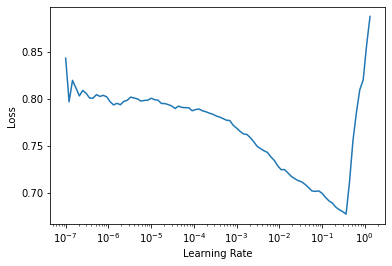

In [ ]:
learn.lr_find()

In [ ]:
lr = 3e-2
lr *= bs/48
lr

0.07999999999999999

In [ ]:
learn.fine_tune(5, lr, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.583410,0.532070,0.721544,0.676049,0.637803,0.645888,00:04


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.503615,0.556113,0.727483,0.714626,0.745039,0.713701,00:05
1,0.473116,0.480366,0.764104,0.795888,0.648088,0.658774,00:06
2,0.436046,0.465296,0.793138,0.779701,0.721554,0.738046,00:06
3,0.388071,0.457359,0.799406,0.778689,0.741443,0.754443,00:05
4,0.354695,0.461108,0.799736,0.773581,0.753146,0.761471,00:06


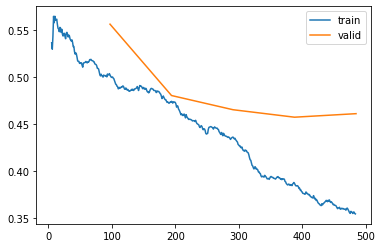

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.export()